## Building a Basic Recommendation System

Check out the turorial on recommendation sysytem using following link.please upvote if you like the kernel.
And suggestions are always welcome.

https://www.kaggle.com/uttam94/recommendation-system

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
! ls ../input/tmdb-movie-metadata

In [ ]:
#https://www.kaggle.com/tmdb/tmdb-movie-metadata
credits = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_credits.csv")

In [ ]:
movies_df = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_movies.csv")

In [ ]:
credits.head()

In [ ]:
movies_df.head()

In [ ]:
print("Credits:",credits.shape)
print("Movies Dataframe:",movies_df.shape)

In [ ]:
credits_column_renamed = credits.rename(index=str, columns={"movie_id": "id"})
movies_df_merge = movies_df.merge(credits_column_renamed, on='id')
movies_df_merge.head()

In [ ]:
movies_cleaned_df = movies_df_merge.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries'])
movies_cleaned_df.head()

In [ ]:
movies_cleaned_df.info()

### Using Weighted average for each movie's  Average Rating

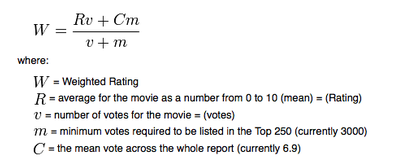


                  Source: http://trailerpark.weebly.com/imdb-rating.html?source=post_page---------------------------

In [ ]:
# Calculate all the components based on the above formula
v=movies_cleaned_df['vote_count']
R=movies_cleaned_df['vote_average']
C=movies_cleaned_df['vote_average'].mean()
m=movies_cleaned_df['vote_count'].quantile(0.70)

In [ ]:
movies_cleaned_df['weighted_average']=((R*v)+ (C*m))/(v+m)

In [ ]:
movies_cleaned_df.head()

In [ ]:
movie_sorted_ranking=movies_cleaned_df.sort_values('weighted_average',ascending=False)
movie_sorted_ranking[['original_title', 'vote_count', 'vote_average', 'weighted_average', 'popularity']].head(20)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

weight_average=movie_sorted_ranking.sort_values('weighted_average',ascending=False)
plt.figure(figsize=(12,6))
axis1=sns.barplot(x=weight_average['weighted_average'].head(10), y=weight_average['original_title'].head(10), data=weight_average)
plt.xlim(4, 10)
plt.title('Best Movies by average votes', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')
plt.savefig('best_movies.png')

In [ ]:
popularity=movie_sorted_ranking.sort_values('popularity',ascending=False)
plt.figure(figsize=(12,6))
ax=sns.barplot(x=popularity['popularity'].head(10), y=popularity['original_title'].head(10), data=popularity)

plt.title('Most Popular by Votes', weight='bold')
plt.xlabel('Score of Popularity', weight='bold')
plt.ylabel('Movie Title', weight='bold')
plt.savefig('best_popular_movies.png')

In [ ]:
popularity.head()

### Recommendation based on scaled weighted average and popularity score(Priority is given 50% to both)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaling=MinMaxScaler()
movie_scaled_df=scaling.fit_transform(movies_cleaned_df[['weighted_average','popularity']])
movie_normalized_df=pd.DataFrame(movie_scaled_df,columns=['weighted_average','popularity'])
movie_normalized_df.head()

In [ ]:
movies_cleaned_df[['normalized_weight_average','normalized_popularity']]= movie_normalized_df

In [ ]:
movies_cleaned_df.head()

In [ ]:
movies_cleaned_df['score'] = movies_cleaned_df['normalized_weight_average'] * 0.5 + movies_cleaned_df['normalized_popularity'] * 0.5
movies_scored_df = movies_cleaned_df.sort_values(['score'], ascending=False)
movies_scored_df[['original_title', 'normalized_weight_average', 'normalized_popularity', 'score']].head(20)

In [ ]:

scored_df = movies_cleaned_df.sort_values('score', ascending=False)

plt.figure(figsize=(16,6))

ax = sns.barplot(x=scored_df['score'].head(10), y=scored_df['original_title'].head(10), data=scored_df, palette='deep')

#plt.xlim(3.55, 5.25)
plt.title('Best Rated & Most Popular Blend', weight='bold')
plt.xlabel('Score', weight='bold')
plt.ylabel('Movie Title', weight='bold')

plt.savefig('scored_movies.png')

### Content Based Recommendation System

Now lets make a recommendations based on the movie’s plot summaries given in the overview column. So if our user gives us a movie title, our goal is to recommend movies that share similar plot summaries.

In [ ]:
movies_cleaned_df.head(1)['overview']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using Abhishek Thakur's arguments for TF-IDF
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

# Filling NaNs with empty string
movies_cleaned_df['overview'] = movies_cleaned_df['overview'].fillna('')

In [ ]:
# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(movies_cleaned_df['overview'])

In [ ]:
tfv_matrix.shape

In [ ]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [ ]:
# Reverse mapping of indices and movie titles
indices = pd.Series(movies_cleaned_df.index, index=movies_cleaned_df['original_title']).drop_duplicates()

In [ ]:
indices

In [ ]:
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return movies_cleaned_df['original_title'].iloc[movie_indices]

In [ ]:
# Testing our content-based recommendation system with the seminal film Spy Kids
give_rec('Spy Kids')

In [ ]:
import pandas as pd
tmdb_5000_credits = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_credits.csv")
tmdb_5000_movies = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_movies.csv")